# Dataset generation

In [1]:
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt


2025-02-03 13:35:50.238907: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 13:35:50.247640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738586150.257084   10151 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738586150.260063   10151 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 13:35:50.271131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Load dataset

In [2]:
data = np.load('./segmented_train_set.npz')
full_slices = data['full_slices'][:,:,:,0]
segmented_full_slices = data['segmented_full_slices'][:,:,:,0]
masks = data['masks']
labels = data['labels']

segmented_full_slices = np.expand_dims(segmented_full_slices, -1)
full_slices = np.expand_dims(full_slices, -1)
masks = np.expand_dims(masks, -1)

segmented_full_slices =  np.uint8(segmented_full_slices)
full_slices =  np.uint8(full_slices)
masks =  np.uint8(masks)

print("segmented_full_slices shape: ", segmented_full_slices.shape)
print("full_slices shape: ", full_slices.shape)
print("masks shape: ", masks.shape)
print("tumor_classes shape: ", labels.shape)

del data

segmented_full_slices shape:  (3089, 512, 512, 1)
full_slices shape:  (3089, 512, 512, 1)
masks shape:  (3089, 512, 512, 1)
tumor_classes shape:  (3089,)


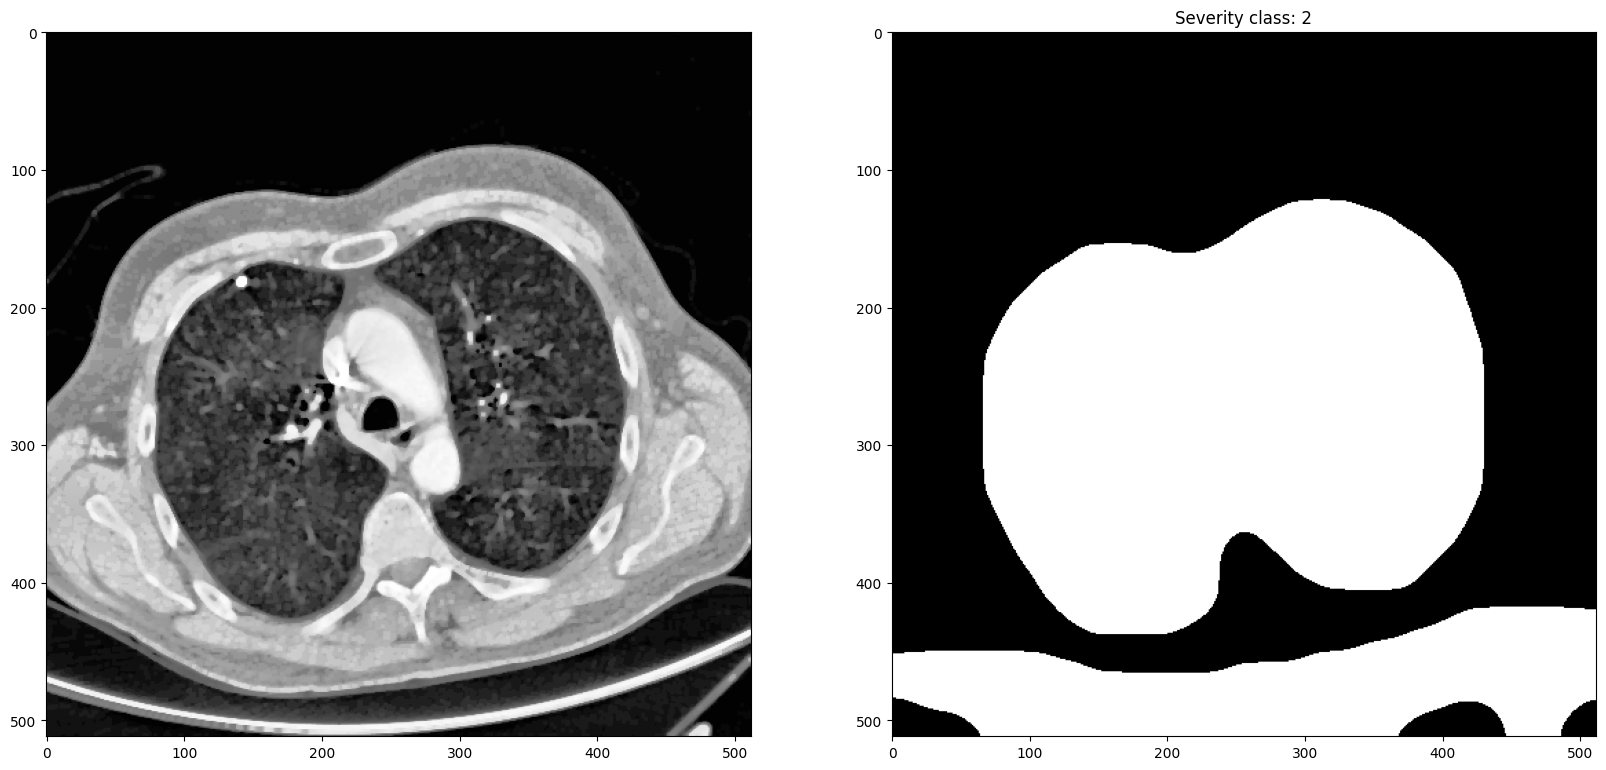

In [3]:
IMAGE_IDX = 0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title(f"Severity class: {labels[IMAGE_IDX]}")

ax1.imshow(full_slices[IMAGE_IDX], cmap='grey')
ax2.imshow(masks[IMAGE_IDX], cmap='grey')

plt.show()

The images are already "enhanced" so not much to do

## Data balancing

In [4]:
# subtract 1 from the class encoding because to_categorical expects starting index = 0
label_one_hot = tfk.utils.to_categorical(labels - 1, num_classes=5)
label_one_hot

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [5]:
from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weight(Y):
    y_integers = np.argmax(Y, axis=1)
    return compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)    

[1.14407407 0.91390533 0.76555143 0.99967638 1.37901786]


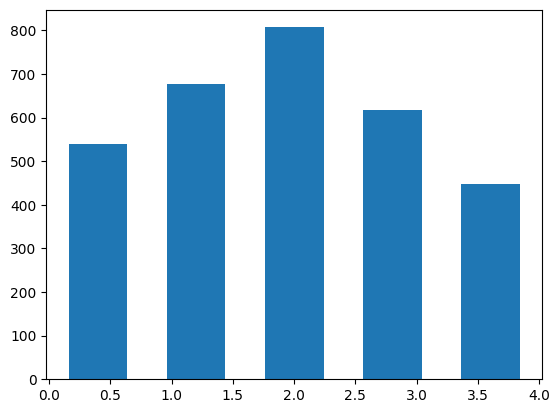

In [6]:
# Starting class weights (inverse frequencies)
class_weights = calculate_class_weight(label_one_hot)

plt.hist(np.argmax(label_one_hot, -1), bins=5,rwidth=0.6)
print(class_weights)

# d_class_weights = dict(enumerate(class_weights))

# import json # Just to prettify the debug
# print(json.dumps(d_class_weights, sort_keys=True, indent=1))

I0000 00:00:1738585924.144865    8356 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13875 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


[1.00709534 1.00375691 0.99496166 1.00044053 0.99387309]


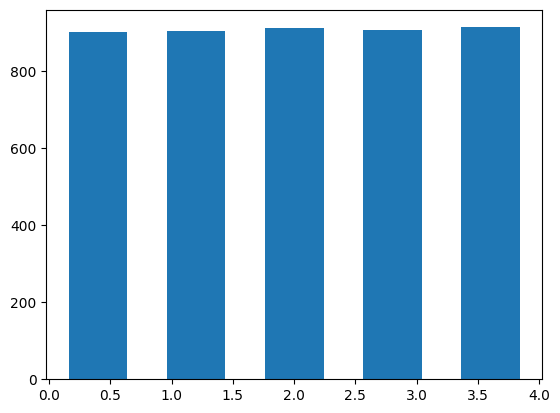

In [7]:
# Balance the dataset by applying random rotations

slices_balanced, segmented_slices_balanced, masks_balanced, labels_balanced = [], [], [], []
slices_balanced.extend(full_slices)
segmented_slices_balanced.extend(segmented_full_slices)
masks_balanced.extend(masks)
labels_balanced.extend(label_one_hot)


# Initial weights
class_weights = calculate_class_weight(labels_balanced)

p = 0.5
epsilon = 0.01 # make this smaller to have even more balancing

# Repeat this while minority class is "too much infrequent"
while np.max(class_weights) > 1 + epsilon: 
    
    dataset = zip(slices_balanced, segmented_slices_balanced, masks_balanced, labels_balanced)
    infrequent_images = [(img, s_img, msk, lbl) for (img, s_img, msk, lbl) in dataset if class_weights[np.argmax(lbl)] > 1]

    # Apply augmentation if class is infrequent
    for img, s_img, msk, lbl in infrequent_images:
        # Don't augment every single infrequent images, otherwise the algorithm is unstable
        if p > np.random.rand():
            seed = np.random.randint(100000)
            img_aug = tfkl.RandomRotation(0.9, seed = seed)(img)
            s_img_aug = tfkl.RandomRotation(0.9, seed = seed)(s_img)
            msk_aug = tfkl.RandomRotation(0.9, seed = seed)(msk)
            slices_balanced.append(img_aug)
            segmented_slices_balanced.append(s_img_aug)
            masks_balanced.append(msk_aug)
            labels_balanced.append(lbl)

    # Recalculate weights
    class_weights = calculate_class_weight(labels_balanced)
    p *= 0.5 # Geometric decrease of augmentation probability

slices_balanced = np.asarray(slices_balanced)
segmented_slices_balanced = np.asarray(segmented_slices_balanced)
masks_balanced = np.asarray(masks_balanced)
labels_balanced = np.asarray(labels_balanced)

plt.hist(np.argmax(labels_balanced, -1), bins=5,rwidth=0.6)
print(class_weights)

### THIS PART OF THE CODE IS USEFUL IN CASE OF MEMORY RESOURCE PROBLEMS

In [8]:
# Save intermediate dataset to be safe

temp_dataset = {
    "full_slices": slices_balanced,
    "segmented_full_slices": segmented_slices_balanced,
    "masks": masks_balanced,
    "labels": labels_balanced
}


np.savez_compressed("./temp_dataset.npz", **temp_dataset)

In [2]:
data = np.load("./temp_dataset.npz")

## Radiomics features extraction

In [3]:
# Extract radiomics features
from radiomics import featureextractor
import SimpleITK as sitk
from tqdm import tqdm
import concurrent.futures


extractor = featureextractor.RadiomicsFeatureExtractor()

extractor.disableAllFeatures()  # Disable all features first
extractor.enableFeaturesByName( # Enable all features except shape features (veeeeery slow to compute)
    firstorder=[], 
    glcm=[], 
    gldm=[], 
    glrlm=[], 
    ngtdm=[],
    glszm=[]
)

length = len(data["full_slices"])

def extract_features(img_mask_pair):
    img, mask = img_mask_pair
    img = sitk.GetImageFromArray(img)
    mask = sitk.GetImageFromArray(mask)
    return list(extractor.execute(img, mask).items())[22:]

img_mask_pairs = zip(data["full_slices"], data["masks"])

with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor: # Concurrent extraction of the features
    radiomics_features = list(tqdm(executor.map(extract_features, img_mask_pairs), total=length, desc="Extracting features"))

radiomics_features = np.asarray(radiomics_features)

print(radiomics_features.shape)

Extracting features:   0%|          | 0/4542 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Extracting features:   0%|          | 1/4542 [00:00<18:22,  4.12it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Extracting features:   0%|          | 9/4542 [00:00<04:55, 15.32it/s]GLCM is symmetrical, therefore Sum Average = 2 * 

(4542, 93, 2)


In [4]:
final_dataset = {
    "full_slices": data["full_slices"],
    "segmented_full_slices": data["segmented_full_slices"],
    "masks": data["masks"],
    "radiomics": radiomics_features,
    "labels": data["labels"]
}


np.savez_compressed("./balanced_masked_slices_radiomics.npz", **final_dataset)